## Problema 1 - generar datos y comparar barras de error

Se piden intervalos de confianza/"error bars" para varias distribuciones. Genero 2,000 muestras por cada configuracion (3 gaussianas, 2 uniformes, 3 betas) para estimar la media y aplicar Chebyshev y Hoeffding como en el enunciado.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Recordatorio rápido del tercer tutorial

En este problema queremos construir intervalos de confianza para la media
usando Chebyshev y Hoeffding y comparar los anchos para varias
distribuciones.

---

Chebyshev para la media 

Para la media muestral $\bar X$ de una variable con varianza $\sigma^2$:

$$
P(|\bar X - \mu| \ge \varepsilon)
\le \frac{\sigma^2}{n\,\varepsilon^2}.
$$

Si pedimos un nivel $1-\alpha$ y hacemos que el lado derecho sea $\alpha$:

$$
\varepsilon = \sqrt{\frac{\sigma^2}{n\alpha}}.
$$

Como $\sigma^2$ no la sabemos, usamos la **varianza muestral**
$\hat\sigma^2$ y el intervalo de Chebyshev queda:

$$
\bar X \pm \sqrt{\frac{\hat\sigma^2}{n\alpha}}.
$$

---

Hoeffding

Si sabemos que $X_i \in [a,b]$, Hoeffding da:

$$
P(|\bar X - \mu| \ge \varepsilon)
\le 2\exp\!\left(-\frac{2n\varepsilon^2}{(b-a)^2}\right).
$$

Imponiendo nivel $1-\alpha$:

$$
\varepsilon = (b-a)\sqrt{\frac{\ln(2/\alpha)}{2n}},
$$

y el intervalo de Hoeffding es

$$
\bar X \pm (b-a)\sqrt{\frac{\ln(2/\alpha)}{2n}}.
$$

En las uniformesy Betas usamos sus rangos reales $[a,b]$.  
En las normales, como no están acotadas, tomamos un rango aproximado
$\mu \pm 4\sigma$ solo para poder comparar numéricamente con Chebyshev.


In [ ]:


def hoeffding_interval(sample, low, high, alpha=0.05):
    n = len(sample)
    width = (high - low) * np.sqrt(np.log(2 / alpha) / (2 * n))
    mean = sample.mean()
    return mean - width, mean + width, 2 * width 

# Chebyshev usaa la varianza muestral (ddof=1) 
def chebyshev_interval(sample, alpha=0.05):
    n = len(sample)
    mean = sample.mean()
    var = sample.var(ddof=1)
    width = np.sqrt(var / (n * alpha))
    return mean - width, mean + width, var, 2 * width

rng = np.random.default_rng(42) 
N = 2000
alpha = 0.05
rows = []  

# Gaussianas: copio los parametros del ejercicio y acoto con mu +/- 4*sigma para poder usar Hoeffding.
for mu, var in [(0, 1), (0, 4), (3, 1)]:
    sigma = np.sqrt(var)
    data = rng.normal(mu, sigma, size=N)
    cheb_low, cheb_high, var_hat, cheb_width = chebyshev_interval(data, alpha)
    bounds = (mu - 4 * sigma, mu + 4 * sigma)
    hoe_low, hoe_high, hoe_width = hoeffding_interval(data, *bounds, alpha)
    rows.append(dict(
        distribution=f"Normal(mu={mu}, var={var})",
        mean_hat=float(data.mean()),
        var_hat=float(var_hat),
        chebyshev_low=cheb_low,
        chebyshev_high=cheb_high,
        chebyshev_width=cheb_width,
        hoeffding_low=hoe_low,
        hoeffding_high=hoe_high,
        hoeffding_width=hoe_width,
        bounds=f"[{bounds[0]:.2f}, {bounds[1]:.2f}]"
    ))

for a, b in [(0, 1), (2, 5)]:
    data = rng.uniform(a, b, size=N)
    cheb_low, cheb_high, var_hat, cheb_width = chebyshev_interval(data, alpha)
    hoe_low, hoe_high, hoe_width = hoeffding_interval(data, a, b, alpha)
    rows.append(dict(
        distribution=f"Uniform({a},{b})",
        mean_hat=float(data.mean()),
        var_hat=float(var_hat),
        chebyshev_low=cheb_low,
        chebyshev_high=cheb_high,
        chebyshev_width=cheb_width,
        hoeffding_low=hoe_low,
        hoeffding_high=hoe_high,
        hoeffding_width=hoe_width,
        bounds=f"[{a:.2f}, {b:.2f}]"
    ))

# Betas:siempre dentro de [0,1], por eso fijo esas cotas en Hoeffding.
for a, b in [(0.5, 0.5), (2, 5), (5, 1)]:
    data = rng.beta(a, b, size=N)
    cheb_low, cheb_high, var_hat, cheb_width = chebyshev_interval(data, alpha)
    hoe_low, hoe_high, hoe_width = hoeffding_interval(data, 0, 1, alpha)
    rows.append(dict(
        distribution=f"Beta(alpha={a}, beta={b})",
        mean_hat=float(data.mean()),
        var_hat=float(var_hat),
        chebyshev_low=cheb_low,
        chebyshev_high=cheb_high,
        chebyshev_width=cheb_width,
        hoeffding_low=hoe_low,
        hoeffding_high=hoe_high,
        hoeffding_width=hoe_width,
        bounds="[0.00, 1.00]"
    ))

df = pd.DataFrame(rows)
pd.set_option('display.precision', 4)
print(df)



                distribution  mean_hat  var_hat  chebyshev_low  \
0        Normal(mu=0, var=1)   -0.0551   1.0041        -0.1553   
1        Normal(mu=0, var=4)    0.0322   3.9731        -0.1671   
2        Normal(mu=3, var=1)    3.0139   1.0190         2.9129   
3               Uniform(0,1)    0.5047   0.0821         0.4760   
4               Uniform(2,5)    3.5007   0.7547         3.4139   
5  Beta(alpha=0.5, beta=0.5)    0.5039   0.1221         0.4690   
6      Beta(alpha=2, beta=5)    0.2851   0.0257         0.2691   
7      Beta(alpha=5, beta=1)    0.8369   0.0197         0.8229   

   chebyshev_high  chebyshev_width  hoeffding_low  hoeffding_high  \
0          0.0451           0.2004        -0.2981          0.1878   
1          0.2316           0.3987        -0.4536          0.5181   
2          3.1148           0.2019         2.7709          3.2568   
3          0.5333           0.0573         0.4743          0.5350   
4          3.5876           0.1737         3.4096          3

La tabla siguiente resume, para cada distribución, la media muestral $\hat\mu$, la varianza empírica $\hat\sigma^2$ y los intervalos de confianza al 95 % construidos con Chebyshev y Hoeffding.

- **Normales**  
  - Para $N(0,1)$ y $N(3,1)$ el ancho de Chebyshev es aproximadamente $0.20$, mientras que para $N(0,4)$ sube a $\approx 0.40$, es decir, prácticamente el doble, como cabría esperar al pasar de varianza $1$ a varianza $4$ (Chebyshev escala con $\sqrt{\hat\sigma^2}$).  
  - Hoeffding produce anchos de $\approx 0.49$, $\approx 0.97$ y $\approx 0.49$ respectivamente, reflejando que el rango usado es $\mu \pm 4\sigma$ (rangos de $8\sigma$, $16\sigma$ y $8\sigma$). Aquí Hoeffding se vuelve mucho más conservador que Chebyshev por culpa de estas cotas amplias y artificiales.

- **Uniformes $\mathcal U(0,1)$ y $\mathcal U(2,5)$**  
  - Para $[0,1]$, Chebyshev y Hoeffding dan anchos muy parecidos ($\approx 0.057$ frente a $\approx 0.061$).  
  - Para $[2,5]$ ocurre lo mismo ($\approx 0.174$ frente a $\approx 0.182$). Esto confirma el comportamiento esperado: al conocer exactamente el rango $[a,b]$, Hoeffding ya es bastante informativo, y Chebyshev, usando una varianza cercana al máximo posible para ese rango, no mejora mucho el resultado.

- **Distribuciones Beta en $[0,1]$**  
  - Hoeffding da siempre el mismo ancho $\approx 0.061$, porque solo depende del rango fijo $[0,1]$ y del tamaño muestral.  
  - Chebyshev refleja la varianza real: la $\text{Beta}(0.5,0.5)$ (muy dispersa) tiene un ancho $\approx 0.070$, mientras que las $\text{Beta}(2,5)$ y $\text{Beta}(5,1)$ (más concentradas) tienen anchos mucho menores ($\approx 0.032$ y $\approx 0.028$). De nuevo se ve que Chebyshev puede proporcionar intervalos significativamente más estrechos cuando la distribución está concentrada, mientras que Hoeffding permanece igual de conservador.

En resumen, **Hoeffding** es puramente _range-based_ y tiende a ser más conservador, especialmente cuando el rango es amplio o artificial (caso normal), mientras que **Chebyshev** utiliza información de la varianza y produce intervalos más ajustados en distribuciones con poca dispersión.

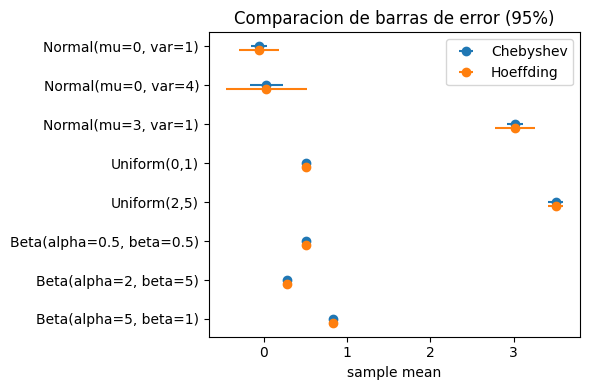

In [ ]:

fig, ax = plt.subplots(figsize=(6, 4))
y = np.arange(len(df))
ax.errorbar(df['mean_hat'], y, xerr=df['chebyshev_width']/2, fmt='o', label='Chebyshev')
ax.errorbar(df['mean_hat'], y + 0.1, xerr=df['hoeffding_width']/2, fmt='o', label='Hoeffding')
ax.set_yticks(y)
ax.set_yticklabels(df['distribution'])
ax.invert_yaxis()
ax.set_xlabel('sample mean')
ax.set_title('Comparacion de barras de error (95%)')
ax.legend()
plt.tight_layout()



La figura anterior muestra las barras de error al 95 % para la media muestral de cada distribución, obtenidas con las desigualdades de Chebyshev (azul) y Hoeffding (naranja). En el eje vertical se representan las distintas distribuciones y en el eje horizontal la media muestral $\bar x$.

- En las distribuciones normales las barras de Hoeffding son claramente más anchas que las de Chebyshev. Para poder aplicar Hoeffding hemos introducido cotas artificiales $\mu \pm 4\sigma$, lo que induce un rango muy grande y, por tanto, intervalos muy conservadores. Chebyshev, en cambio, se basa en la varianza empírica y produce barras más ajustadas alrededor de la media muestral.

- En las uniforme donde sí conocemos el rango exacto, las barras obtenidas por Chebyshev y Hoeffding prácticamente coinciden. Esto es coherente con la teoría: la varianza de una uniforme en $[a,b]$ es cercana al máximo posible dado el rango $(b-a)$, de modo que ambos métodos aprovechan información muy similar.

- En las Betas, todas acotadas en $[0,1]$, Hoeffding genera barras de igual longitud para las tres distribuciones (solo depende del rango). Chebyshev, en cambio, se adapta a la dispersión real: la $\text{Beta}(0.5,0.5)$ es más diseminada y da barras más anchas, mientras que las $\text{Beta}(2,5)$ y $\text{Beta}(5,1)$ están mucho más concentradas y producen barras significativamente más estrechas. Esto ilustra cómo Chebyshev se beneficia de una varianza pequeña, mientras que Hoeffding ignora la forma de la distribución más allá del rango.

En todos los casos las barras están centradas muy cerca de la media teórica, lo que indica que con $N=2000$ muestras la media muestral es un estimador muy estable.


## Problema 2 - comparar con valores teoricos
En este apartado comparo las estimaciones numéricas con los valores teóricos
de cada distribución (media, varianza y ancho de los IC), usando las fórmulas
cerradas del tutorial para reconstruir los anchos de Chebyshev y Hoeffding.


Para cada distribución conocemos la media y la varianza teóricas:

- Normal$(\mu,\sigma^2)$: $\mu$, $\sigma^2$.
- Uniforme$(a,b)$: $\mu = (a+b)/2$, $\ \sigma^2 = (b-a)^2/12$.
- Beta$(\alpha,\beta)$: $\mu = \alpha/(\alpha+\beta)$,  
  $\sigma^2 = \alpha\beta / \big((\alpha+\beta)^2(\alpha+\beta+1)\big)$.

A partir de estas expresiones he construido una tabla donde comparo:

- $\hat\mu$ (media muestral) frente a $\mu_{\text{teo}}$,
- $\hat\sigma^2$ (varianza muestral) frente a $\sigma^2_{\text{teo}}$,
- el ancho del intervalo de Chebyshev usando varianza muestral
  frente al ancho usando la varianza teórica,
- el ancho del intervalo de Hoeffding obtenido a partir del rango
  teórico $[a,b]$ de cada distribución.


In [9]:
sample_size = 2000
alpha_level = 0.05  

theoretical = {
    "Normal(mu=0, var=1)": {"mean": 0.0, "var": 1.0, "bounds": (-4.0, 4.0)},
    "Normal(mu=0, var=4)": {"mean": 0.0, "var": 4.0, "bounds": (-8.0, 8.0)},
    "Normal(mu=3, var=1)": {"mean": 3.0, "var": 1.0, "bounds": (-1.0, 7.0)},
    "Uniform(0,1)": {"mean": 0.5, "var": (1.0 - 0.0) ** 2 / 12.0, "bounds": (0.0, 1.0)},
    "Uniform(2,5)": {"mean": (2.0 + 5.0) / 2.0, "var": (5.0 - 2.0) ** 2 / 12.0, "bounds": (2.0, 5.0)},
    "Beta(alpha=0.5, beta=0.5)": {"mean": 0.5 / (0.5 + 0.5), "var": 0.5 * 0.5 / (((0.5 + 0.5) ** 2) * (0.5 + 0.5 + 1.0)), "bounds": (0.0, 1.0)},
    "Beta(alpha=2, beta=5)": {"mean": 2.0 / 7.0, "var": 2.0 * 5.0 / (((7.0) ** 2) * (7.0 + 1.0)), "bounds": (0.0, 1.0)},
    "Beta(alpha=5, beta=1)": {"mean": 5.0 / 6.0, "var": 5.0 * 1.0 / (((6.0) ** 2) * (6.0 + 1.0)), "bounds": (0.0, 1.0)},
}

comparison = df.copy()
comparison['mean_theory'] = comparison['distribution'].map(lambda d: theoretical[d]['mean'])
comparison['var_theory'] = comparison['distribution'].map(lambda d: theoretical[d]['var'])
comparison['mean_error'] = comparison['mean_hat'] - comparison['mean_theory']
comparison['var_error'] = comparison['var_hat'] - comparison['var_theory']
comparison['chebyshev_width_theory'] = comparison['distribution'].map(
    lambda d: 2 * np.sqrt(theoretical[d]['var'] / (sample_size * alpha_level))
)
comparison['chebyshev_width_delta'] = comparison['chebyshev_width'] - comparison['chebyshev_width_theory']
hoeff_factor = np.sqrt(np.log(2 / alpha_level) / (2 * sample_size))
comparison['hoeffding_width_theory'] = comparison['distribution'].map(
    lambda d: 2 * (theoretical[d]['bounds'][1] - theoretical[d]['bounds'][0]) * hoeff_factor
)
comparison['hoeffding_width_delta'] = comparison['hoeffding_width'] - comparison['hoeffding_width_theory']
cols = [
    'distribution',
    'mean_hat', 'mean_theory', 'mean_error',
    'var_hat', 'var_theory', 'var_error',
    'chebyshev_width', 'chebyshev_width_theory', 'chebyshev_width_delta',
    'hoeffding_width', 'hoeffding_width_theory', 'hoeffding_width_delta'
]
# print(comparison[cols].to_string(index=False))
display(comparison[cols])


,distribution,mean_hat,mean_theory,mean_error,var_hat,var_theory,var_error,chebyshev_width,chebyshev_width_theory,chebyshev_width_delta,hoeffding_width,hoeffding_width_theory,hoeffding_width_delta
0,"Normal(mu=0, var=1)",-0.0551,0.0000,-0.0551,1.0041,1.0000,0.0041,0.2004,0.2000,0.0004,0.4859,0.4859,0.0
1,"Normal(mu=0, var=4)",0.0322,0.0000,0.0322,3.9731,4.0000,-0.0269,0.3987,0.4000,-0.0013,0.9718,0.9718,0.0
2,"Normal(mu=3, var=1)",3.0139,3.0000,0.0139,1.0190,1.0000,0.0190,0.2019,0.2000,0.0019,0.4859,0.4859,0.0
3,"Uniform(0,1)",0.5047,0.5000,0.0047,0.0821,0.0833,-0.0013,0.0573,0.0577,-0.0004,0.0607,0.0607,0.0
4,"Uniform(2,5)",3.5007,3.5000,0.0007,0.7547,0.7500,0.0047,0.1737,0.1732,0.0005,0.1822,0.1822,0.0
5,"Beta(alpha=0.5, beta=0.5)",0.5039,0.5000,0.0039,0.1221,0.1250,-0.0029,0.0699,0.0707,-0.0008,0.0607,0.0607,0.0
6,"Beta(alpha=2, beta=5)",0.2851,0.2857,-0.0006,0.0257,0.0255,0.0002,0.0321,0.0319,0.0001,0.0607,0.0607,0.0
7,"Beta(alpha=5, beta=1)",0.8369,0.8333,0.0035,0.0197,0.0198,-0.0002,0.0280,0.0282,-0.0001,0.0607,0.0607,0.0


### Comentario Problema 2
- Las medias y varianzas muestrales están muy cerca de los valores teóricos
  (errores pequeños en todas las filas), como cabe esperar con $N=2000$.
- El ancho de Chebyshev calculado con la varianza muestral prácticamente
  coincide con el ancho teórico usando $\sigma^2$ exacta
  (las diferencias son del orden de $10^{-3}$).
- Para Hoeffding el ancho teórico y el empírico son iguales, porque solo
  depende del rango $[a,b]$, de $N$ y de $\alpha$; en las normales esto se
  hace usando el truncado a $\mu \pm 4\sigma$ .